# Sample code for Assignment 3

## Basic SVM code  for wine

In [1]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, random_state=0)
print(X_train.shape, X_test.shape)

(133, 13) (45, 13)


In [2]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import numpy as np
svm = SVC()
np.mean(cross_val_score(svm, X_train, y_train))

0.3910056071330086

In [3]:
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

0.5111111111111111

### Comments for task 4

The accuracy is very low, and the estimate of accuracy produced by cross-validation is a gross underestimate.

In [4]:
# In the following code I have tried different normalizers
# (StandardScaler, MinMaxScaler, RobustScaler, Normalizer)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.model_selection import GridSearchCV
pipe = make_pipeline(StandardScaler(), SVC())
param_grid = {'svc__C': [0.01, 0.1, 1, 10, 100], 'svc__gamma': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy:", grid.best_score_)
print("Test set score:", grid.score(X_test, y_test))
print("Best parameters:", grid.best_params_)

Best cross-validation accuracy: 0.9774436090225563
Test set score: 0.9777777777777777
Best parameters: {'svc__C': 1, 'svc__gamma': 0.01}


### Comments for task 5

Any of the three scalers and parameter selection improve the results drastically (98% for StandardScaler).  The normalizer gives results that are much worse but not hopeless (score of 91%).

## Cross-conformal predictor for wine

First we split the indices of the training set into 3 folds.

In [5]:
from sklearn.model_selection import KFold
kf = KFold(shuffle=True, random_state=0, n_splits=3)

Let now compute the p-values, as in Chapter 9.

In [6]:
n_train = X_train.shape[0]  # size of the test set
n_test = X_test.shape[0]  # size of the test set
n_classes = 3  # number of classes
p = np.zeros((n_test, n_classes))  # initializing the array of p-values
ranks = np.zeros((n_test, n_classes))  # initializing the array for accumulating ranks
for rest_index, fold_index in kf.split(X_train):
  X_rest, X_fold = X_train[rest_index], X_train[fold_index]
  y_rest, y_fold = y_train[rest_index], y_train[fold_index]
  grid.fit(X_rest, y_rest)
  df_fold = grid.decision_function(X_fold)
  df_test = grid.decision_function(X_test)
  n_fold = X_fold.shape[0]   # size of the current fold
  alpha_fold = np.zeros(n_fold)  # initializing the conformity scores for the fold
  for i in range(n_fold):
    alpha_fold[i] = df_fold[i,y_fold[i]]  # conformity score of the ith element of the fold
  for j in range(n_test):
    for l in range(n_classes):
      ranks[j,l] = ranks[j,l] + np.sum(alpha_fold <= df_test[j,l])
# turning accumulated ranks into p-values:
p = (ranks+1) / (n_train+1)

Now let us use the code given in Lab Worksheet 9 for plotting the calibration curve.

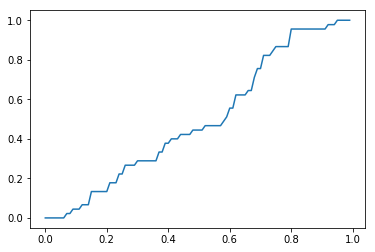

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
eps = np.zeros(100) # a range of significance levels
err = np.zeros(100) # the corresponding error rates
for k in range(100):
  eps[k] = k/100 # considering eps = k%
  err[k] = 0 # initializing the error rate
  for j in range(n_test):
    if (p[j,y_test[j]] <= eps[k]): # if we made an error
      err[k] = err[k] + 1 # count this error
  err[k] = err[k] / n_test # number of errors -> error rate
plt.plot(eps, err)

Now let's find the average false p-value.

In [8]:
sum_p_values = 0
for j in range(n_test):
  sum_p_values = sum_p_values + p[j,0] + p[j,1] + p[j,2] - p[j,y_test[j]]
print(sum_p_values / (n_test*2))

0.013930348258706458


## Neural net code  for wine

In [9]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
np.mean(cross_val_score(mlp, X_train, y_train))

0.3527514783834298

In [10]:
mlp.fit(X_train, y_train)
mlp.score(X_test, y_test)

0.35555555555555557

Let us see what the default parameters are:

In [11]:
mlp

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

### Comments for task 4

The accuracy is even worse than it was for SVM, but the estimate of accuracy produced by cross-validation is OK.

In [12]:
# In the following code I have tried different normalizers
# (StandardScaler, MinMaxScaler, RobustScaler, Normalizer)
pipe = make_pipeline(Normalizer(), MLPClassifier())
param_grid = {'mlpclassifier__learning_rate_init': [0.001, 0.01, 0.1],
  'mlpclassifier__hidden_layer_sizes': [(10,), (100,), (10,10)]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy:", grid.best_score_)
print("Test set score:", grid.score(X_test, y_test))
print("Best parameters:", grid.best_params_)

C:\Users\uhac013\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\uhac013\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\uhac013\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\uhac013\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, 

Best cross-validation accuracy: 0.7969924812030075
Test set score: 0.9555555555555556
Best parameters: {'mlpclassifier__hidden_layer_sizes': (10,), 'mlpclassifier__learning_rate_init': 0.1}


C:\Users\uhac013\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Comments for task 5

Any of the three scalers and parameter selection improve the results drastically (96% for StandardScaler, slightly worse than for SVM).  It's interesting that the normalizer also gives a good result (score of 96%).

## Basic SVM code  for USPS

In [13]:
original_train_data = np.genfromtxt("zip.train.gz", usecols=np.arange(1,257), dtype='float')
original_test_data = np.genfromtxt("zip.test.gz", usecols=np.arange(1,257), dtype='float')
original_data = np.row_stack((original_train_data, original_test_data))

In [14]:
original_train_target = np.genfromtxt("zip.train.gz", usecols=0, dtype='int')
original_test_target = np.genfromtxt("zip.test.gz", usecols=0, dtype='int')
original_target = np.append(original_train_target, original_test_target)

In [15]:
original_target.shape

(9298,)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(original_data, original_target, random_state=100)
print(X_train.shape, X_test.shape)

(6973, 256) (2325, 256)


In [17]:
# In addition to what I did for the wine dataset, I will time the classifier.
import time
start = time.time()
print(np.mean(cross_val_score(svm, X_train, y_train)))
print(time.time() - start, "seconds")

0.9663001483442297
18.09667944908142 seconds


In [18]:
import time
start = time.time()
svm.fit(X_train, y_train)
print(svm.score(X_test, y_test))
print(time.time() - start, "seconds")

0.9638709677419355
11.90822982788086 seconds


### Comments for task 4

The accuracy appears quite good (perhaps because the digits are already normalized), and the estimate of accuracy produced by cross-validation is also good.

In [19]:
# In the following code I have tried different scalers
# (StandardScaler, MinMaxScaler, RobustScaler).
# The default value of gamma is 1 / n_features = 1/256.
# The default value of C is 1.
# For a param_grid of size 4, about 9 minutes (although it might become slower for larger C).
# Since the code runs so slowly now I will remember different grids (giving them different names)
#   so that I can reuse them easily.
import time
start = time.time()
pipe = make_pipeline(StandardScaler(), SVC())
param_grid = {'svc__C': [1, 10], 'svc__gamma': [0.01, 0.1]}
grid_s_svc = GridSearchCV(pipe, param_grid=param_grid)
grid_s_svc.fit(X_train, y_train)
print("Best cross-validation accuracy:", grid_s_svc.best_score_)
print("Test set score:", grid_s_svc.score(X_test, y_test))
print("Best parameters:", grid_s_svc.best_params_)
print(time.time() - start, "seconds")

Best cross-validation accuracy: 0.9297289545389359
Test set score: 0.9341935483870968
Best parameters: {'svc__C': 10, 'svc__gamma': 0.01}
520.7920281887054 seconds


In [20]:
# This is identical to the previous cell, except that now we use Normalizer.
# For a param_grid of size 4, about 5 minutes.
import time
start = time.time()
pipe = make_pipeline(Normalizer(), SVC())
param_grid = {'svc__C': [1, 10], 'svc__gamma': [0.01, 0.1]}
grid_n_svc = GridSearchCV(pipe, param_grid=param_grid)
grid_n_svc.fit(X_train, y_train)
print("Best cross-validation accuracy:", grid_n_svc.best_score_)
print("Test set score:", grid_n_svc.score(X_test, y_test))
print("Best parameters:", grid_n_svc.best_params_)
print(time.time() - start, "seconds")

Best cross-validation accuracy: 0.959414885988814
Test set score: 0.9539784946236559
Best parameters: {'svc__C': 10, 'svc__gamma': 0.1}
286.6835927963257 seconds


### Comments for task 5

The normalizer and parameter selection do not improve the results.  The three scalers make results worse but surprisingly they do not become hopeless.

## Cross-conformal predictor for USPS

First we compute the p-values, as in Chapter 9.  We can use either one of the grids or svm (which as we know works fine, even without preprocessing and with the default values of parameters).

In [21]:
# About 7 minutes.
import time
start = time.time()
n_train = X_train.shape[0]  # size of the test set
n_test = X_test.shape[0]  # size of the test set
n_classes = 10  # number of classes
p = np.zeros((n_test, n_classes))  # initializing the array of p-values
ranks = np.zeros((n_test, n_classes))  # initializing the array for accumulating ranks
for rest_index, fold_index in kf.split(X_train):
  X_rest, X_fold = X_train[rest_index], X_train[fold_index]
  y_rest, y_fold = y_train[rest_index], y_train[fold_index]
  grid_n_svc.fit(X_rest, y_rest)
  df_fold = grid_n_svc.decision_function(X_fold)
  df_test = grid_n_svc.decision_function(X_test)
  n_fold = X_fold.shape[0]   # size of the current fold
  alpha_fold = np.zeros(n_fold)  # initializing the conformity scores for the fold
  for i in range(n_fold):
    alpha_fold[i] = df_fold[i,y_fold[i]]  # conformity score of the ith element of the fold
  for j in range(n_test):
    for l in range(n_classes):
      ranks[j,l] = ranks[j,l] + np.sum(alpha_fold <= df_test[j,l])
# turning accumulated ranks into p-values:
p = (ranks+1) / (n_train+1)
print(time.time() - start, "seconds")

433.49270725250244 seconds


Now let us use the code given in Lab Worksheet 9 for plotting the calibration curve.

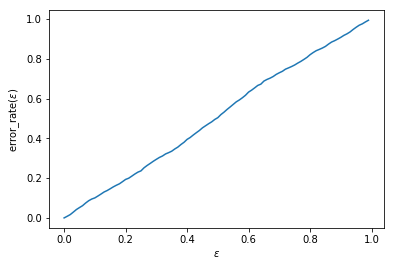

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
eps = np.zeros(100) # a range of significance levels
err = np.zeros(100) # the corresponding error rates
for k in range(100):
  eps[k] = k/100 # considering eps = k%
  err[k] = 0 # initializing the error rate
  for j in range(n_test):
    if (p[j,y_test[j]] <= eps[k]): # if we made an error
      err[k] = err[k] + 1 # count this error
  err[k] = err[k] / n_test # number of errors -> error rate
plt.plot(eps, err)
plt.xlabel('$\epsilon$')
plt.ylabel('error_rate($\epsilon$)')
plt.gcf().savefig('09_cal_curve.jpg',format='jpg',dpi=300)  # saving for Chapter 9

Now let's find the average false p-value.

In [23]:
sum_p_values = 0
for j in range(n_test):
  sum_p_values = sum_p_values + p[j,0] + p[j,1] + p[j,2] + p[j,3] + p[j,4] + p[j,5] + p[j,6] + p[j,7] + p[j,8] + p[j,9]  - p[j,y_test[j]]
print(sum_p_values / (n_test*9))

0.007790540663238938


## Neural net code  for USPS

In [24]:
import time
start = time.time()
mlp = MLPClassifier()
print(np.mean(cross_val_score(mlp, X_train, y_train)))
print(time.time() - start, "seconds")

0.9630046265373565
19.171876430511475 seconds


In [25]:
import time
start = time.time()
mlp.fit(X_train, y_train)
print(mlp.score(X_test, y_test))
print(time.time() - start, "seconds")

0.9655913978494624
8.514398336410522 seconds


### Comments for task 4

The accuracy is good (close to what we get for SVM), and the estimate of accuracy produced by cross-validation is also good.

In [26]:
# In the following code I have tried different scalers
# (StandardScaler, MinMaxScaler, RobustScaler).
# About 2 minutes.
import time
start = time.time()
pipe = make_pipeline(StandardScaler(), MLPClassifier())
param_grid = {'mlpclassifier__learning_rate_init': [0.001, 0.01, 0.1],
  'mlpclassifier__hidden_layer_sizes': [(10,), (100,), (10,10)]}
grid_s_mlp = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid_s_mlp.fit(X_train, y_train)
print("Best cross-validation accuracy:", grid_s_mlp.best_score_)
print("Test set score:", grid_s_mlp.score(X_test, y_test))
print("Best parameters:", grid_s_mlp.best_params_)
print(time.time() - start, "seconds")

C:\Users\uhac013\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\uhac013\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\uhac013\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\uhac013\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, 

Best cross-validation accuracy: 0.9675892729097949
Test set score: 0.9647311827956989
Best parameters: {'mlpclassifier__hidden_layer_sizes': (100,), 'mlpclassifier__learning_rate_init': 0.01}
172.5464310646057 seconds


In [27]:
# This is identical to the previous cell except that now Normalizer is used.
# About 2 minutes.
import time
start = time.time()
pipe = make_pipeline(Normalizer(), MLPClassifier())
param_grid = {'mlpclassifier__learning_rate_init': [0.001, 0.01, 0.1],
  'mlpclassifier__hidden_layer_sizes': [(10,), (100,), (10,10)]}
grid_n_mlp = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid_n_mlp.fit(X_train, y_train)
print("Best cross-validation accuracy:", grid_n_mlp.best_score_)
print("Test set score:", grid_n_mlp.score(X_test, y_test))
print("Best parameters:", grid_n_mlp.best_params_)
print(time.time() - start, "seconds")

C:\Users\uhac013\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\uhac013\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\uhac013\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\uhac013\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, 

Best cross-validation accuracy: 0.9638606051914528
Test set score: 0.9643010752688173
Best parameters: {'mlpclassifier__hidden_layer_sizes': (100,), 'mlpclassifier__learning_rate_init': 0.01}
268.43754267692566 seconds


### Comments for task 5

The default values of parameters are OK, and parameter selection does not improve the results. Normalizer works fine (although it does not improve the results), and the scalers do not make the results substantially worse.